In [1]:
# !pip install imblearn

In [2]:
# !pip freeze > requirements.txt

In [3]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

In [4]:
df = pd.read_csv('train.csv',index_col=0)

In [5]:
y = df.Survived
X = df.drop('Survived',axis=1)

In [6]:
df.columns.values
len(df.columns.values)

11

In [7]:
skew_feats=df.skew().sort_values(ascending=False)
skewness=pd.DataFrame({'Skew':skew_feats})
skewness=skewness[abs(skewness)>0.75].dropna()

In [8]:
df.isnull().sum().sort_values(ascending=False)

Cabin       673
Age         175
Embarked      2
Fare          0
Ticket        0
Parch         0
SibSp         0
Sex           0
Name          0
Pclass        0
Survived      0
dtype: int64

In [9]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Embarked', 'Sex', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [11]:
processed_data = preprocessor.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(processed_data, y, test_size=0.2)

<AxesSubplot:>

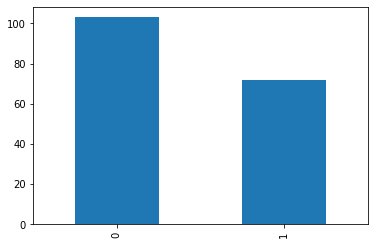

In [13]:
pd.Series(y_test).value_counts().plot(kind='bar') # equal sampling now (check)

In [14]:
untest = RandomUnderSampler()
X_untest, y_untest = untest.fit_sample(X_test, y_test)

<AxesSubplot:>

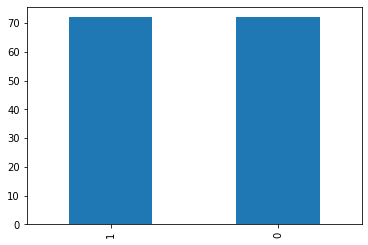

In [15]:
pd.Series(y_untest).value_counts().plot(kind='bar') # equal sampling now (check)

In [16]:
model=RandomForestClassifier(n_estimators=4000, max_features='auto', max_depth=20,
                           min_samples_split=5, min_samples_leaf=1,
                           bootstrap=True, criterion='gini')

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=4000)

In [17]:
print("model score: %.3f" % model.score(X_test, y_test))

model score: 0.857


In [18]:
# predict test Y values
ypred=model.predict(X_untest)

# apply to test set
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_untest, ypred))

# confusion matrix to evaluate predictions
pd.crosstab(y_untest, ypred, rownames=['Observed'], colnames=['Predicted'])

Accuracy: 0.8402777777777778


Predicted,0,1
Observed,,
0,66,6
1,17,55


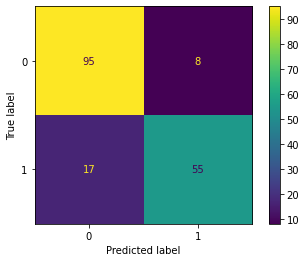

In [19]:
plot_confusion_matrix(model, X_test, y_test)  
plt.show()  # doctest: +SKIP

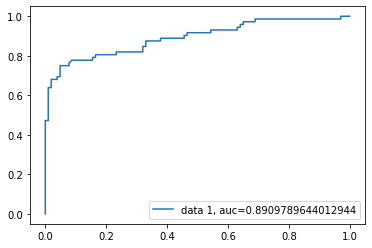

In [20]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()